# Project #2: Deduce the dependence of variability of AGN
See [Google Doc](https://docs.google.com/document/d/1yb43z7vrG5-FIL6lNZjVkIx41jKSCl698d51RQhXRqg/edit?tab=t.0) for more info.

This project is broken into the following steps:
1. Import Data
2. Crossmatch
3. Binning
4. Measure structure function
5. Visualize

This notebook assumes the user already has a local hatsified SDSS DR7 QSO catalog. 

This can be acquired using the included scripts `dl_sdss_dr7qso.sh` and `import_sdss_dr7sqo.py`, or obtained and converted from [this page](https://das.sdss.org/va/qso_properties_dr7/dr7.htm) on the SDSS website.

In [1]:
from dask.distributed import Client

client = Client(n_workers=4, memory_limit="auto")
client

/opt/lsst/software/stack/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40103 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40103/status,
Dashboard: http://127.0.0.1:40103/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40999,Workers: 4
Dashboard: http://127.0.0.1:40103/status,Total threads: 4
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:44427,Total threads: 1
Dashboard: http://127.0.0.1:45621/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:46619,


# Import Data

Select a large number of AGNs. Use SDSS AGN to start.  Find these AGNs in ZTF/PanSTARRS/Rubin ComCam data.

### Import SDSS (DR7QSO)

In [2]:
import hats
import lsdb
from hats.io.validation import is_valid_catalog

In [3]:
sdss_dir = "/sdf/data/rubin/u/olynn/sdss/sdss/"

In [4]:
print("Valid catalog?", is_valid_catalog(sdss_dir))

sdss_hats = hats.read_hats(sdss_dir)

Valid catalog? True


In [5]:
sdss = lsdb.read_hats(
    sdss_dir,
    columns=["RA", "DEC", "REDSHIFT", "SDSS_NAME", "LOGBH"]
)

In [6]:
sdss.head()

,RA,DEC,REDSHIFT,SDSS_NAME,LOGBH
_healpix_29,,,,,
1748843545125,45.075508,0.152306,2.2308,030018.12+000908.3,9.273159
2976627715402,44.884758,0.164801,0.8064,025932.34+000953.2,8.307456
5459300610667,45.18858,0.282409,1.7422,030045.25+001656.6,9.3182
5858887011909,45.339138,0.290646,0.4101,030121.39+001726.3,7.203714
7934686108383,45.189484,0.35918,1.4969,030045.47+002133.0,9.479626


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'SDSS DR7 QSO'}>)

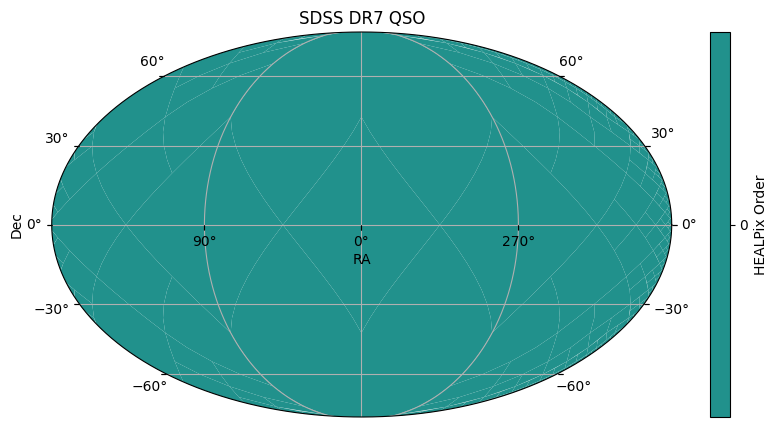

In [7]:
sdss.plot_pixels(plot_title="SDSS DR7 QSO")

### Import ZTF (w/ Margin Cache)

In [8]:
from lsdb import BoxSearch

surveys_path = "https://data.lsdb.io/hats"
ztf_object_path = f"{surveys_path}/ztf_dr14/ztf_object"
ztf_margin_path = f"{surveys_path}/ztf_dr14/ztf_object_10arcs"
ztf = lsdb.read_hats(
    ztf_object_path, margin_cache=ztf_margin_path, columns=["ra", "dec"]
)
print(f"Margin size: {ztf.margin.hc_structure.catalog_info.margin_threshold} arcsec")

Margin size: 10.0 arcsec


(<Figure size 1000x500 with 2 Axes>, <WCSAxes: title={'center': 'ztf_object'}>)

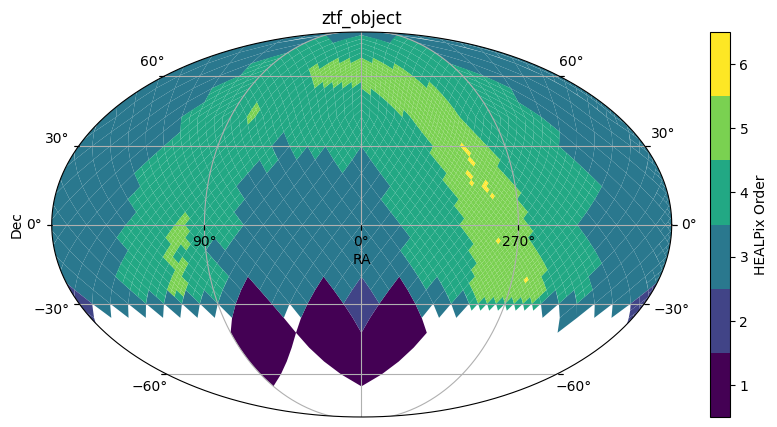

In [9]:
ztf.plot_pixels(plot_title="ztf_object")

# Crossmatch

In [10]:
sdss_x_ztf = sdss.crossmatch(ztf, n_neighbors=1, radius_arcsec=3)

In [11]:
sdss_x_ztf

,RA_sdss,DEC_sdss,REDSHIFT_sdss,SDSS_NAME_sdss,LOGBH_sdss,ra_ztf_dr14,dec_ztf_dr14,_dist_arcsec
npartitions=485,,,,,,,,
"Order: 3, Pixel: 0",double[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow]
"Order: 3, Pixel: 1",...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
"Order: 4, Pixel: 3070",...,...,...,...,...,...,...,...
"Order: 4, Pixel: 3071",...,...,...,...,...,...,...,...


(<Figure size 1000x500 with 2 Axes>, <WCSAxes: title={'center': 'SDSS x ZTF'}>)

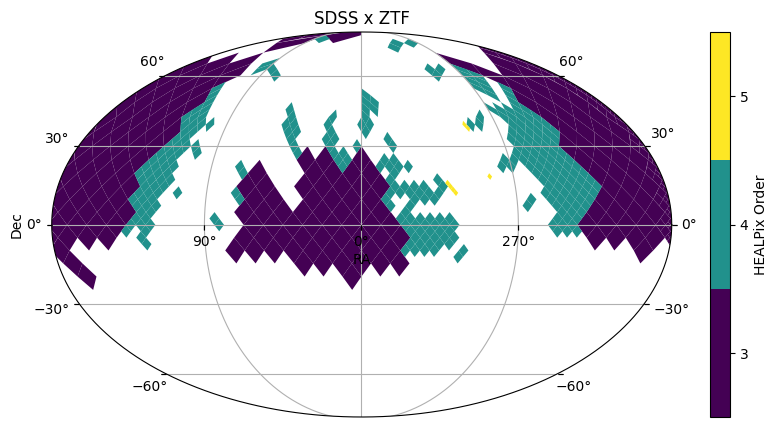

In [12]:
sdss_x_ztf.plot_pixels(plot_title="SDSS x ZTF")

In [13]:
#result_df = sdss_x_ztf.compute()  # To compute values to a pandas DataFrame
#sdss_x_ztf.to_hats("./sdss_x_ztf")  # To save (needed for large results, as they won't fit in df

## A Small Intermission to Figure Out Why Our SDSSDR7QSO Cat seems weird
*Did it import properly? Why does it seem to be missing many columns?*

In [14]:
#print(len(str(hats.read_hats(sdss_dir).schema).split("\n")), " cols found.\n")
#print(" | ".join(str(hats.read_hats(sdss_dir).schema).split("\n")))

In [15]:
#!tree "$sdss_dir"

In [16]:
import pandas as pd

def inspect_parquet(file_path, num_rows=5):
    try:
        # Load the Parquet file
        df = pd.read_parquet(file_path)
        # Display schema
        print(f"Schema of the Parquet file ({file_path}):")
        print(df.info())
        print("\n")
        # Display a preview of the data
        print(f"Preview of the first {num_rows} rows:")
        print(df.head(num_rows))
        # Display summary statistics
        print("\nSummary statistics:")
        print(df.describe(include='all'))
    except Exception as e:
        print(f"An error occurred: {e}")

In [17]:
#file_path = os.path.join(sdss_dir, "dataset", "Norder=0", "Dir=0", "Npix=0.parquet")
#inspect_parquet(file_path)

*Ohh...it was just that [the SDSS DR7 QSO catalog](https://classic.sdss.org/dr7/products/value_added/qsocat_dr7.php) requires the [supplemental materials of the SDSS DR7 QSO catalog](https://das.sdss.org/va/qso_properties_dr7/dr7.htm). In fact, for our purposes, we can just target the supplemental catalog alone. Back to our regularly scheduled programming:*

# Binning

Instructions:
> Split the sample in mass and redshift (several bins in redshift and several bins in mass). For instance see [Figure 4](https://s3.amazonaws.com/aasie/images/0004-637X/834/2/111/apjaa4d0bf4_hr.jpg) in [Neven's paper](https://ui.adsabs.harvard.edu/abs/2017ApJ...834..111C/graphics).

**Question: Do we have mass? What kind?**

**Answer: Yes--**  
From [the SDSS paper](https://iopscience.iop.org/article/10.1088/0067-0049/194/2/45):
> We also compile virial black hole mass estimates based on various calibrations. For the fiducial virial mass estimates we use the Vestergaard & Peterson (VP06) calibrations for Hβ and C iv, and our own calibration for Mg ii which matches the VP06 Hβ masses on average.  
> ...  
> 139...	DOUBLE	The adopted fiducial virial BH mass [log (MBH, vir/M☉)]  
> 140...	DOUBLE	Uncertainty in the fiducial virial BH mass (measurement uncertainty only)  

From the [SDSS DR7 QSO (SM) page](https://das.sdss.org/va/qso_properties_dr7/dr7.htm):
> 139	**LOGBH**	DOUBLE	The adopted fiducial virial BH mass (Msun)  
> 140	**LOGBH_ERR**	DOUBLE	Measurement error in LOGBH

**Question: What's the best practice for binning these?**  
Do I just add another column with "z_bin", etc? (Adding cols via [assign](https://docs.lsdb.io/en/stable/autoapi/lsdb/catalog/index.html#lsdb.catalog.Catalog.assign)?)

**Answer: No best practice known!**

## Let's start by looking at the column stats

In [18]:
sdss_hats = hats.read_hats(sdss_dir)
sdss_hats.aggregate_column_statistics(include_columns=["RA", "DEC", "REDSHIFT", "LOGBH", "LOGBH_ERR"])

,column_names,min_value,max_value,null_count
0,RA,0.027228,359.997681,0.0
1,DEC,-17.520441,84.431412,0.0
2,REDSHIFT,0.064500,5.460800,0.0
3,LOGBH,-0.000000,11.310795,0.0
4,LOGBH_ERR,-1.000000,1.999996,0.0


It looks like 6 redshift bins (<1, 1-2, 2-3, 3-4, 4-5, >5) would be a good place to start.  
Similarly, we could try 6 mass (logbh) bins (<2, 2-4, 4-6, 6-8, 8-10, >10).  
Let's take a quick peak at the distribution in the first 100 rows: 

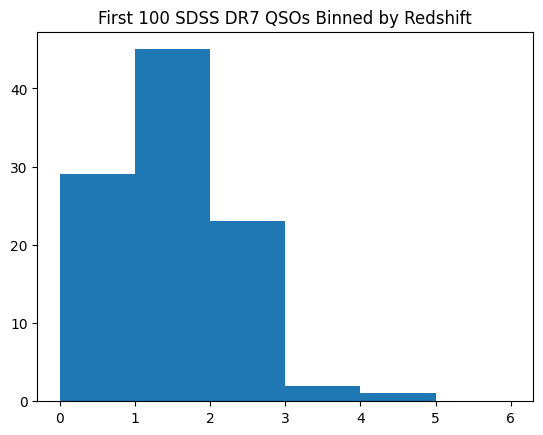

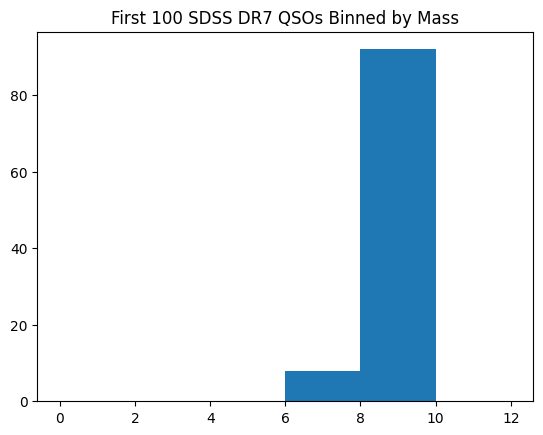

In [19]:
import numpy as np
import matplotlib.pyplot as plt

sdss_x_ztf_subset = sdss_x_ztf.head(100)

redshifts = np.array(sdss_x_ztf_subset["REDSHIFT_sdss"])
masses = np.array(sdss_x_ztf_subset["LOGBH_sdss"])

plt.hist(redshifts, bins=np.linspace(0.0, 6.0, 7))
plt.title("First 100 SDSS DR7 QSOs Binned by Redshift")
plt.show()
plt.hist(masses, bins=np.linspace(0.0, 12.0, 7))
plt.title("First 100 SDSS DR7 QSOs Binned by Mass")
plt.show()

Tbh, they seem more skewed than I'd prefer.  
But, this is only the first 100 of 105,000+ rows, so let's go ahead with this for now, and we can come back later if we want.

In [20]:
def bin_redshift(val):
    return val.astype(int)
def bin_mass(val):
    return (val*0.5).astype(int)

sdss_x_ztf = sdss_x_ztf.assign(redshift_bin=lambda x: bin_redshift(x['REDSHIFT_sdss']))
sdss_x_ztf = sdss_x_ztf.assign(mass_bin=lambda x: bin_mass(x['LOGBH_sdss']))

In [21]:
sdss_x_ztf.head()

,RA_sdss,DEC_sdss,REDSHIFT_sdss,SDSS_NAME_sdss,LOGBH_sdss,ra_ztf_dr14,dec_ztf_dr14,_dist_arcsec,redshift_bin,mass_bin
_healpix_29,,,,,,,,,,
1748843545125,45.075508,0.152306,2.2308,030018.12+000908.3,9.273159,45.075482,0.152342,0.160074,2,4
2976627715402,44.884758,0.164801,0.8064,025932.34+000953.2,8.307456,44.884731,0.164863,0.244233,0,4
5459300610667,45.18858,0.282409,1.7422,030045.25+001656.6,9.3182,45.188562,0.282455,0.17765,1,4
5858887011909,45.339138,0.290646,0.4101,030121.39+001726.3,7.203714,45.33912,0.290674,0.119384,0,3
7934686108383,45.189484,0.35918,1.4969,030045.47+002133.0,9.479626,45.18947,0.359212,0.125918,1,4


---

# Measure structure function for these subsamples
Instructions:
> Measure structure function for these subsamples. Decide by yourself how you will measure structure function (i.e., make the function from scratch, use implementation shown on the Internet, etc…).

# Visualize
Visualize the result and show how the variability of AGN (measured structure function) depends on the mass and redshift. If possible, expand the results with a larger Miliquas catalog.